# Astronomaly

This notebook is designed to replicate the feature extraction methods of Astronomaly. In addition, the steps are shown individually and explained in order to provide better detail in the processes of Astronomaly. The notebook would thus ideally serve as a troubleshooting method for Astronomaly.

________________

In [1]:
from astronomaly.base.base_pipeline import PipelineStage
from astronomaly.base import logging_tools
from astronomaly.data_management import image_reader
from astronomaly.preprocessing import image_preprocessing
from astronomaly.feature_extraction import power_spectrum, autoencoder
from astronomaly.feature_extraction import shape_features
from astronomaly.dimensionality_reduction import pca
from astronomaly.postprocessing import scaling
from astronomaly.anomaly_detection import isolation_forest, human_loop_learning
from astronomaly.visualisation import tsne
from astronomaly.utils import utils
from astropy.io import fits
from astronomaly.feature_extraction.shape_features import find_contours, fit_ellipse, draw_contour
from astronomaly.feature_extraction.shape_features import get_ellipse_leastsq, extract_contour

import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
image = '/home/verlon/Desktop/Astronomaly/Data/Coadd_0260/0260m062/Input/Failed Images/cutout_26.0835_-6.3682.fits'

In [3]:
image_data = fits.getdata(image)

In [4]:
np.shape(image_data)

(3, 256, 256)

In [5]:
image_data_ = image_data[0,:,:]

In [6]:
image_data_g = image_data[0]
image_data_r = image_data[1]
image_data_z = image_data[2]

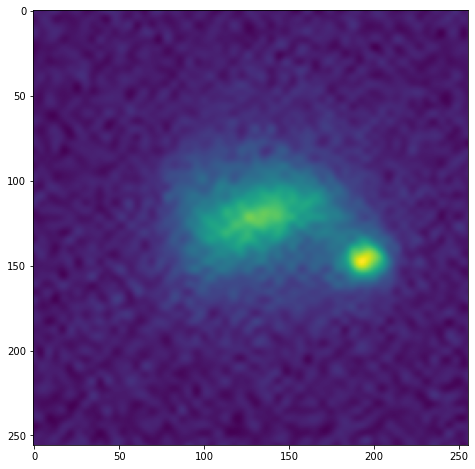

In [7]:
%matplotlib inline
plt.figure(figsize = (8,8))
plt.imshow(image_data_g)
plt.show()

import matplotlib.pyplot as plt
from astropy.visualization import make_lupton_rgb
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

image_data_g = image_data[0]
image_data_r = image_data[1]
image_data_z = image_data[2]

rgb_default = make_lupton_rgb(image_data_z, image_data_r, image_data_g, Q = 10, stretch=0.4)

plt.figure(figsize = (8,8))
plt.imshow(rgb_default, origin='lower')

import pylab

fig = pylab.gcf()
image_data[0] = r 
image_data[1] = g 
image_data[2] = b 

pylab.imshow(image_data, interpolation='nearest', origin='lower')
pylab.axis('off')

import scipy

image_data = np.empty((20,20,4), np.uint8) # assuming 8 bits per channnel
image_data[0,:,:] = scipy.misc.bytescale(r) # red
image_data[0,:,:] = scipy.misc.bytescale(g) # green
image_data[0,:,:] = scipy.misc.bytescale(b) # blue
image_data[:,:,3] = 255 # Alpha transparency
image_data = scipy.misc.imresize(image_data, (width/2, height/2), interp='bicubic')
scipy.misc.imsave('rgb.png', image_data)

from PIL import Image
import numpy as np
rgbArray = np.zeros((256,256,3), 'uint8')
rgbArray[..., 0] = image_data[0,:,:]*256
rgbArray[..., 1] = image_data[1,:,:]*256
rgbArray[..., 2] = image_data[2,:,:]*256
img = Image.fromarray(rgbArray)

img

_____________

### Setting up the data

#### This section contains all of the relevant data and parameters that are to be specified in order for Astronomaly to run. 

In [9]:
coadd_id = '0260'  # Brick code

Some default settings for Astrnomaly to use on optical data

In [10]:
list_of_files = []
window_size = 32
band_prefixes = ['z-', 'r-', 'g-']
bands_rgb = {'r': 'z-', 'g': 'r-', 'b': 'g-'}
plot_cmap = 'hot'
feature_method = 'ellipse'
dim_reduction = ''

In [11]:
image_transform_function = [image_transform_greyscale,
                            image_preprocessing.image_transform_sigma_clipping,
                            # image_preprocessing.image_transform_inverse_sinh,
                            image_preprocessing.image_transform_scale
                            ]

display_transform_function = [# image_preprocessing.image_transform_inverse_sinh
                            image_preprocessing.image_transform_scale
                              ]

The data directory can be set up to shorten other directories and assists in sorting out the data storage. Due to the large number of bricks involved, it is much simpler to merely change the brick name than the entire directory all the time

In [12]:
data_dir = '/home/verlon/Desktop/Astronomaly/Data/Coadd_'+str(coadd_id)+'/'

In [13]:
image_dir = os.path.join(data_dir, '0260m062', 'Input', 'Images')
output_dir = os.path.join(data_dir, '0260m062', 'Output', '')

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [14]:
catalogue = pd.read_csv(os.path.join(data_dir,'0260m062','Input','test_catalogue_0260m062_500.csv'))

#catalogue = pd.read_csv(os.path.join(data_dir,'0260m062','Input','test_catalogue_0260m062_500_working.csv'))

## Running Astronomaly

In [15]:
image_dataset = image_reader.ImageDataset(directory=image_dir,
                                          list_of_files=list_of_files,
                                          window_size=window_size,
                                          output_dir=output_dir,
                                          plot_square=False,
                                          transform_function=image_transform_function,
                                          display_transform_function=display_transform_function,
                                          plot_cmap=plot_cmap,
                                          catalogue=catalogue,
                                          band_prefixes=band_prefixes,
                                          bands_rgb=bands_rgb)

Reading image data from /home/verlon/Desktop/Astronomaly/Data/Coadd_0260/0260m062/Input/Images/z-legacysurvey-0260m062-image.fits.fz...


2020-10-15 12:09:26,512 - WARNING - FITSFixedWarning: 'datfix' made the change 'Set DATE-REF to '1858-11-17' from MJD-REF'.


Done!
A catalogue of  500 sources has been provided.


In [16]:
image = image_dataset.get_sample('1487')

#image = image_dataset.get_sample('6095')

In [17]:
np.shape(image)

(32, 32)

TypeError: Image data of dtype <U105 cannot be converted to float

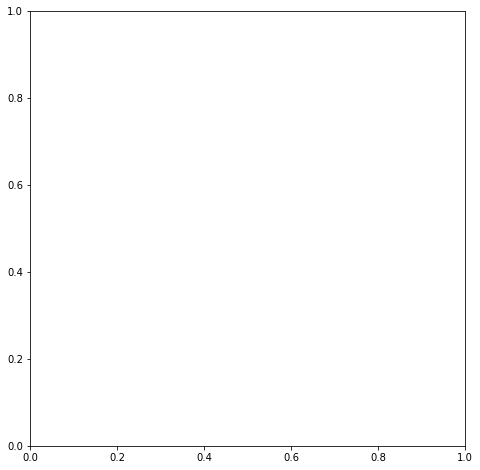

In [20]:
%matplotlib inline
plt.figure(figsize = (8,8))
plt.imshow(image)
plt.show

In [180]:
print(image_g.min())

0.0


In [181]:
new_arr = np.zeros(image_g.shape)

In [182]:
#new_arr[image_g > 0.014149103313684464] = 1
new_arr[image_g > 0] = 1

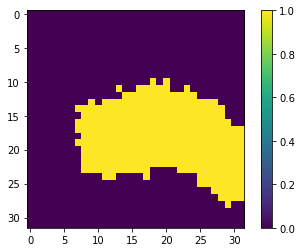

In [183]:
plt.imshow(new_arr)
plt.colorbar()

In [184]:
np.shape(image)

(32, 32, 3)

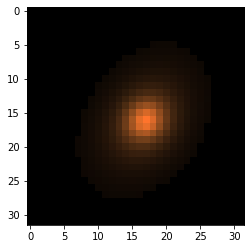

In [185]:
plt.imshow(image)

In [58]:
np.shape(image)

(32, 32, 3)

In [59]:
image_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

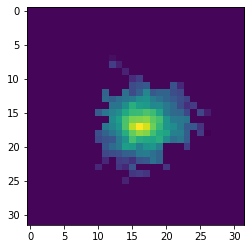

In [60]:
plt.imshow(image_grey)

In [61]:
np.shape(image_grey)

(32, 32)

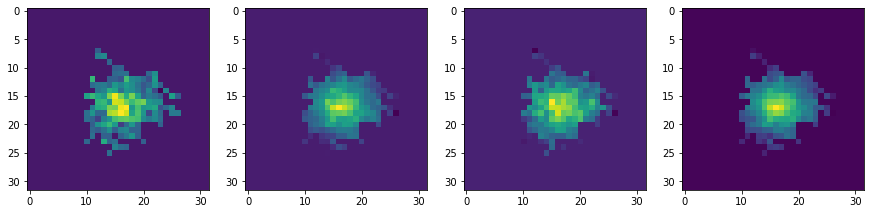

In [62]:
f = plt.figure(figsize=(15, 15))

f.add_subplot(1, 4, 1)
plt.imshow(image[:,:,0])

f.add_subplot(1, 4, 2)
plt.imshow(image[:,:,1])

f.add_subplot(1, 4, 3)
plt.imshow(image[:,:,2])

f.add_subplot(1, 4, 4)
plt.imshow(image_grey)


plt.show(block=True)

In [63]:
image_grey

array([[0.06407534, 0.06407534, 0.06407534, ..., 0.06407534, 0.06407534,
        0.06407534],
       [0.06407534, 0.06407534, 0.06407534, ..., 0.06407534, 0.06407534,
        0.06407534],
       [0.06407534, 0.06407534, 0.06407534, ..., 0.06407534, 0.06407534,
        0.06407534],
       ...,
       [0.06407534, 0.06407534, 0.06407534, ..., 0.06407534, 0.06407534,
        0.06407534],
       [0.06407534, 0.06407534, 0.06407534, ..., 0.06407534, 0.06407534,
        0.06407534],
       [0.06407534, 0.06407534, 0.06407534, ..., 0.06407534, 0.06407534,
        0.06407534]], dtype=float32)

In [8]:
def image_transform_greyscale (img):
    """
    Simple function that combines the rgb bands into a single image.
    
    Parameters
    ----------
    img : np.ndarray
        Input image
        
    Returns
    -------
    np.ndarray
        Greyscale image
        a
    """
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    return img

image_transform_greyscale(image)

plt.imshow(image_transform_greyscale(image))

image = image_grey

In [19]:
percentiles = [90, 80, 70, 60, 50, 0]

In [20]:
percentiles = np.sort(percentiles)[::-1]

feats = []
threshold = []
all_contours = []
all_ellipses = []

x0 = y0 = -1
x_cent = image.shape[0] // 2
y_cent = image.shape[1] // 2

if np.all(image == 0):
    failed = True
    failure_message = "Invalid cutout for feature extraction"
else:
    failed = False
    failure_message = ""

for p in percentiles:
    if failed:
        contours = []
    else:
        thresh = np.percentile(image[image > 0], p)
        contours, hierarchy = find_contours(image, thresh)
        
        print('Percentile = ', p)

        # print(thresh)
        # print(contours)

        x_contours = np.zeros(len(contours))
        y_contours = np.zeros(len(contours))
    
    #thresh = np.percentile(image_66_g[image_66_g > 0], p)

    #contours, hierarchy = find_contours(image_66_g, thresh)

    # print(thresh)
    # print(contours)

    #x_contours = np.zeros(len(contours))
    #y_contours = np.zeros(len(contours))

    if len(contours) != 0:
        for k in range(len(contours)):
            M = cv2.moments(contours[k])
            try:
                x_contours[k] = int(M["m10"] / M["m00"])
                y_contours[k] = int(M["m01"] / M["m00"])
            except ZeroDivisionError:
                pass
        if x0 == -1:
            x_diff = x_contours - x_cent
            y_diff = y_contours - y_cent
        else:
            x_diff = x_contours - x0
            y_diff = y_contours - y0

        # Will try to find the CLOSEST contour to the central one
        r_diff = np.sqrt(x_diff**2 + y_diff**2)

        ind = np.argmin(r_diff)

        if x0 == -1:
            x0 = x_contours[ind]
            y0 = y_contours[ind]

        c = contours[ind]
        
        params = get_ellipse_leastsq(c, image)
        print('Parameter = ', params)
        
        # Params return in this order:
        # residual, x0, y0, maj_axis, min_axis, theta
        if np.any(np.isnan(params)):
            failed = True
        else:
            if params[3] == 0 or params[4] == 0:
                aspect = 1
            else:
                aspect = params[4] / params[3]

            if aspect < 1:
                aspect = 1 / aspect
            if aspect > 100:
                aspect = 1

            new_params = params[:3] + [aspect] + [params[-1]]
            feats.append(new_params)     
        
        
        #######################################################
        arr = image.copy()


        ellipse_arr, param = fit_ellipse(
            c, image, return_params=True, filled=False)
        
        all_ellipses.append(ellipse_arr)
        all_contours.append(c)
        #######################################################
    
    
    else:
        failed = True
        failure_message = "No contour found"
        
    # print(thresh)
    # print(contours)

    print('Contour Length = ',len(contours))
    print()

Percentile =  90
Parameter =  [0.009765625, 16.378143310546875, 16.780231475830078, 4.902750492095947, 5.636335372924805, 114.36402130126953]
Contour Length =  1

Percentile =  80
Parameter =  [0.01171875, 16.39434051513672, 16.743324279785156, 6.733417510986328, 8.424287796020508, 97.11046600341797]
Contour Length =  1

Percentile =  70
Parameter =  [0.0146484375, 16.53602409362793, 16.739534378051758, 8.06382942199707, 10.488739013671875, 102.77694702148438]
Contour Length =  1

Percentile =  60
Parameter =  [0.0244140625, 16.60857582092285, 16.58002281188965, 9.56072998046875, 12.058088302612305, 100.15540313720703]
Contour Length =  1

Percentile =  50
Parameter =  [0.0234375, 16.498546600341797, 16.406463623046875, 10.428736686706543, 13.895791053771973, 95.63238525390625]
Contour Length =  3

Percentile =  0
Parameter =  [0.0771484375, 15.418497085571289, 17.145301818847656, 17.555484771728516, 18.88165283203125, 38.91754913330078]
Contour Length =  1



In [188]:
pipeline_ellipse = shape_features.EllipseFitFeatures(
    percentiles=[90, 80, 70, 60, 50, 0],
    output_dir=output_dir, channel=0, force_rerun=True
)

In [ ]:
features_original = pipeline_ellipse.run_on_dataset(image_dataset)

In [ ]:
features_original

## BACKUP

In [41]:
image = image[:,:,0]

In [64]:
image = image_grey

In [21]:
percentiles = np.sort(percentiles)[::-1]

feats = []
threshold = []
all_contours = []
all_ellipses = []

x0 = y0 = -1
x_cent = image.shape[0] // 2
y_cent = image.shape[1] // 2

for p in percentiles:
    thresh = np.percentile(image[image > 0], p)

    contours, hierarchy = find_contours(image, thresh)
    
    print('Percentile = ', p)
    #print(thresh)
    #print(contours)

    
    x_contours = np.zeros(len(contours))
    y_contours = np.zeros(len(contours))

    if len(contours) != 0:
        for k in range(len(contours)):
            M = cv2.moments(contours[k])
            try:
                x_contours[k] = int(M["m10"] / M["m00"])
                y_contours[k] = int(M["m01"] / M["m00"])
            except ZeroDivisionError:
                pass
        if x0 == -1:
            x_diff = x_contours - x_cent
            y_diff = y_contours - y_cent
        else:
            x_diff = x_contours - x0
            y_diff = y_contours - y0

        # Will try to find the CLOSEST contour to the central one
        r_diff = np.sqrt(x_diff**2 + y_diff**2)

        ind = np.argmin(r_diff)

        if x0 == -1:
            x0 = x_contours[ind]
            y0 = y_contours[ind]

        c = contours[ind]
        
        params = get_ellipse_leastsq(c, image)
        print('Parameter = ', params)

        arr = image.copy()

        #cnt = cv2.drawContours(arr, [c], 0, (1, 1, 1), 1)

        ellipse_arr, params = fit_ellipse(
            c, image, return_params=True, filled=False)

    all_ellipses.append(ellipse_arr)
    all_contours.append(c)
    
    print(thresh)
    #print(contours)
    
    print('Contour Length = ',len(c))
    print()

Percentile =  90
Parameter =  [0.009765625, 16.378143310546875, 16.780231475830078, 4.902750492095947, 5.636335372924805, 114.36402130126953]
0.6105083346366883
Contour Length =  14

Percentile =  80
Parameter =  [0.01171875, 16.39434051513672, 16.743324279785156, 6.733417510986328, 8.424287796020508, 97.11046600341797]
0.4629104197025299
Contour Length =  19

Percentile =  70
Parameter =  [0.0146484375, 16.53602409362793, 16.739534378051758, 8.06382942199707, 10.488739013671875, 102.77694702148438]
0.3828809857368469
Contour Length =  21

Percentile =  60
Parameter =  [0.0244140625, 16.60857582092285, 16.58002281188965, 9.56072998046875, 12.058088302612305, 100.15540313720703]
0.30782487988471985
Contour Length =  29

Percentile =  50
Parameter =  [0.0234375, 16.498546600341797, 16.406463623046875, 10.428736686706543, 13.895791053771973, 95.63238525390625]
0.24705110490322113
Contour Length =  29

Percentile =  0
Parameter =  [0.0771484375, 15.418497085571289, 17.145301818847656, 17.5

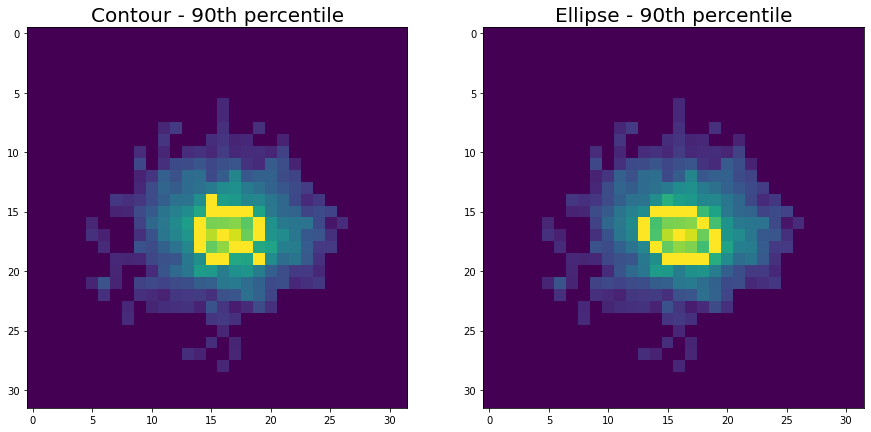

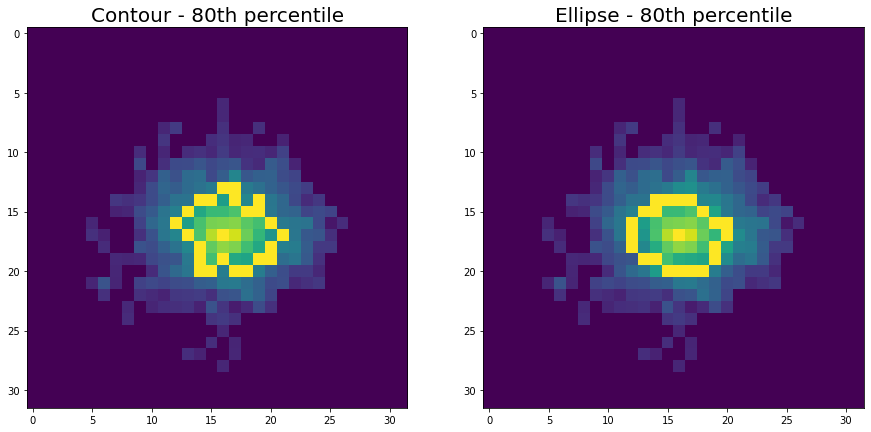

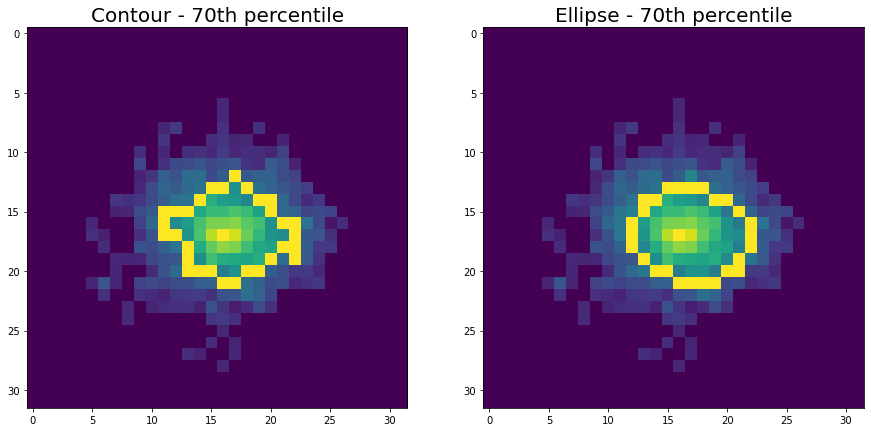

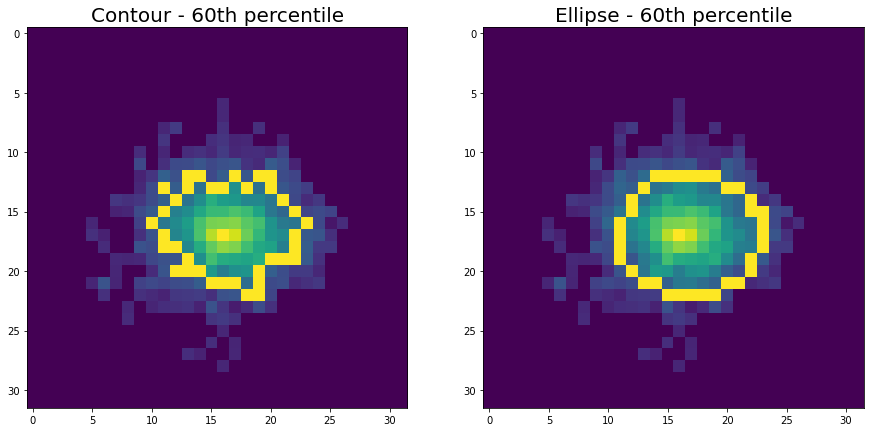

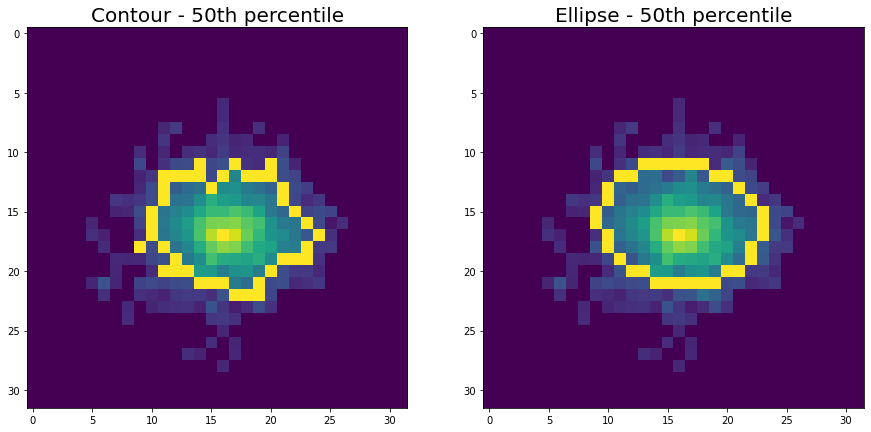

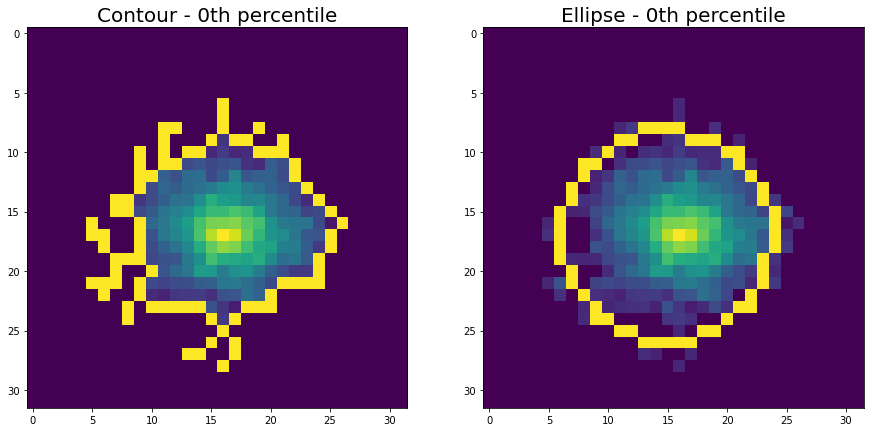

In [22]:
for i in range(len(all_contours)):
    drawn = draw_contour(all_contours[i], image)

    f = plt.figure(figsize=(15, 15))

    f.add_subplot(1, 2, 1)
    plt.imshow(drawn)
    plt.gca().set_title('Contour - ' +
                        str(percentiles[i]) + 'th percentile', fontsize=20)

    f.add_subplot(1, 2, 2)
    plt.imshow(all_ellipses[i])
    plt.gca().set_title('Ellipse - ' +
                        str(percentiles[i]) + 'th percentile', fontsize=20)

    plt.show(block=True)

This function replicates the EllipseFitFeatures class and the contours and ellipses can be drawn from this.

def contours_and_ellipses(image_original, percentiles):

    ## Added this since the get_sample function returns multi-channel data
    image = cv2.cvtColor(image_original, cv2.COLOR_BGR2GRAY)
    
    ## This does not work
    #image = image_original[:, :, 0]

    x0 = y0 = -1
    x_cent = image.shape[0] // 2
    y_cent = image.shape[1] // 2

    feats = []
    all_contours = []
    all_ellipses = []
    all_parameters = []
    # Start with the closest in contour (highest percentile)
    percentiles = np.sort(percentiles)[::-1]

    if np.all(image == 0):
        failed = True
        failure_message = "Invalid cutout for feature extraction"
    else:
        failed = False
        failure_message = ""

    for p in percentiles:
        if failed:
            contours = []
        else:
            thresh = np.percentile(image[image > 0], p)
            contours, hierarchy = find_contours(image, thresh)

            x_contours = np.zeros(len(contours))
            y_contours = np.zeros(len(contours))

        # First attempt to find the central point of the inner most contour
        # if len(contours[0]) != 0:
        if len(contours) != 0:
            for k in range(len(contours)):
                M = cv2.moments(contours[k])
                try:
                    x_contours[k] = int(M["m10"] / M["m00"])
                    y_contours[k] = int(M["m01"] / M["m00"])
                except ZeroDivisionError:
                    pass
            if x0 == -1:
                x_diff = x_contours - x_cent
                y_diff = y_contours - y_cent
            else:
                x_diff = x_contours - x0
                y_diff = y_contours - y0

            # Will try to find the CLOSEST contour to the central one
            r_diff = np.sqrt(x_diff**2 + y_diff**2)

            ind = np.argmin(r_diff)

            if x0 == -1:
                x0 = x_contours[ind]
                y0 = y_contours[ind]

            c = contours[ind]

            params = get_ellipse_leastsq(c, image)
            # Params return in this order:
            # residual, x0, y0, maj_axis, min_axis, theta
            if np.any(np.isnan(params)):
                failed = True
            else:
                if params[3] == 0 or params[4] == 0:
                    aspect = 1
                else:
                    aspect = params[4] / params[3]

                if aspect < 1:
                    aspect = 1 / aspect
                if aspect > 100:
                    aspect = 1

                new_params = params[:3] + [aspect] + [params[-1]]
                feats.append(new_params)
        else:
            failed = True
            failure_message = "No contour found"

        if failed:
            feats.append([np.nan] * 5)
            logging_tools.log(failure_message)

        # Now we have the leastsq value, x0, y0, aspect_ratio, theta for each
        # sigma
        # Normalise things relative to the highest threshold value
        # If there were problems with any sigma levels, set all values to NaNs
        if np.any(np.isnan(feats)):
            return [np.nan] * 4 * len(percentiles)
        else:
            max_ind = np.argmax(percentiles)

            residuals = []
            dist_to_centre = []
            aspect = []
            theta = []

            x0_max_sigma = feats[max_ind][1]
            y0_max_sigma = feats[max_ind][2]
            aspect_max_sigma = feats[max_ind][3]
            theta_max_sigma = feats[max_ind][4]

            for n in range(len(feats)):
                prms = feats[n]
                residuals.append(prms[0])
                if prms[1] == 0 or prms[2] == 0:
                    r = 0
                else:
                    x_diff = prms[1] - x0_max_sigma
                    y_diff = prms[2] - y0_max_sigma
                    r = np.sqrt((x_diff)**2 + (y_diff)**2)
                dist_to_centre.append(r)
                aspect.append(prms[3] / aspect_max_sigma)
                theta_diff = np.abs(prms[4] - theta_max_sigma) % 360
                # Because there's redundancy about which way an ellipse
                # is aligned, we always take the acute angle
                if theta_diff > 90:
                    theta_diff -= 90
                theta.append(theta_diff)

            normalized_parameters = np.hstack(
                (residuals, dist_to_centre, aspect, theta))

        thickness = 1

        arr = image_original.copy()

        cnt = cv2.drawContours(arr, [c], 0, (1, 1, 1), thickness)

        ellipse_arr, params = fit_ellipse(
            c, image_original, return_params=True, filled=False)

        all_contours.append(cnt)
        all_ellipses.append(ellipse_arr)
        all_parameters.append(params)

    return (all_contours, all_ellipses, all_parameters)

In [ ]:
percentiles = [90,80,70,60,50,0]

In [ ]:
contours, ellipse, parameters = contours_and_ellipses(image_66, percentiles)

In [ ]:
plt.imshow(image_66)

In [ ]:
f = plt.figure(figsize = (15,15))

f.add_subplot(1,2, 1)
plt.imshow(contours[0])
plt.gca().set_title('Contour',fontsize = 20)

f.add_subplot(1,2, 2)
plt.imshow(ellipse[0])
plt.gca().set_title('Ellipse',fontsize = 20)
            
plt.show(block=True)

In [ ]:
for p in range(len(percentiles)):
    
    f = plt.figure(figsize = (15,15))

    f.add_subplot(1,2, 1)
    plt.imshow(contours[p])
    plt.gca().set_title('Contour - ' +str(percentiles[p]) + 'th percentile',fontsize = 20)

    f.add_subplot(1,2, 2)
    plt.imshow(ellipse[p])
    plt.gca().set_title('Ellipse - ' +str(percentiles[p]) + 'th percentile',fontsize = 20)
            
    plt.show(block=True)
    

In [ ]:
pipeline_ellipse = shape_features.EllipseFitFeatures(
    percentiles=[90, 80, 70, 60, 50, 0],
    output_dir=output_dir, channel=0, force_rerun=True
)

trial = test[:,:,0]
trial_ = trial.copy()

contours = []
threshold = []
for p in percentiles:
    thresh = np.percentile(trial[trial > 0], p)
    threshold.append(thresh)
    
for i in range(len(threshold)):
    contour, hierarchy = find_contours(trial, threshold[i])
    contours.append(contour)

for p in range(len(contours)):
    draw = cv2.drawContours(trial_, contours[p], 0, (1, 1, 1), 1)
    plt.imshow(draw) #Does not return innermost contours as wanted

In [ ]:
features_original = pipeline_ellipse.run_on_dataset(image_dataset)

features_original

features = features_original.copy()

features

pipeline_scaler = scaling.FeatureScaler(force_rerun=True,
                                        output_dir=output_dir)
features = pipeline_scaler.run(features)

features

pipeline_iforest = isolation_forest.IforestAlgorithm(
    force_rerun=True, output_dir=output_dir)
anomalies = pipeline_iforest.run(features)

pipeline_score_converter = human_loop_learning.ScoreConverter(
    force_rerun=False, output_dir=output_dir)
anomalies = pipeline_score_converter.run(anomalies)
anomalies = anomalies.sort_values('score', ascending=False)

try:
    df = pd.read_csv(
        os.path.join(output_dir, 'ml_scores.csv'),
        index_col=0,
        dtype={'human_label': 'int'})
    df.index = df.index.astype('str')

    if len(anomalies) == len(df):
        anomalies = pd.concat(
            (anomalies, df['human_label']), axis=1, join='inner')
except FileNotFoundError:
    pass

pipeline_active_learning = human_loop_learning.NeighbourScore(
    alpha=1, output_dir=output_dir)

pipeline_tsne = tsne.TSNE_Plot(
    force_rerun=False,
    output_dir=output_dir,
    perplexity=50)
t_plot = pipeline_tsne.run(features.loc[anomalies.index])

image_dataset

features

anomalies

t_plot

from astronomaly.frontend.image_pipeline import run_pipeline

astronomaly = run_pipeline()